# Необходимые библиотеки

In [ ]:
from collections import Counter

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tqdm import tqdm

In [ ]:
# Для красоты отключаем вывод ошибок
import warnings
warnings.filterwarnings('ignore')

# Чтение данных

In [ ]:
# Загрузка данных из файла JSON
file_path = 'data.json'
data = pd.read_json(file_path)

In [ ]:
# Пример данных
data.sample(n=5)

,id,cuisine,ingredients
7828,18654,mexican,"[chopped cilantro fresh, green onions, cooked ..."
10847,4142,italian,"[mayonaise, garlic, fresh parsley, anchovy pas..."
9544,7892,filipino,"[water, yellow onion, whole peppercorn, potato..."
8720,10907,chinese,"[soy sauce, fresh ginger root, green onions, b..."
3766,34412,brazilian,"[fresh lime, passion fruit juice, granulated s..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


Необходимо удалить id, т.к. при обучении он не несет полезной информации.

Также удалим одинаковые рецепты

In [ ]:
# Удаляем id по оси столбцов. inplace изменяет исходный фрейм данных
data.drop('id', axis=1, inplace=True)

In [ ]:
# Отсортировать ингредиенты в каждом списке и преобразовать в строку
data['ingredients_str'] = data['ingredients'].apply(lambda x: ' '.join(sorted(x)))

# Проверка на дубликаты с учетом отсортированных строк ингредиентов
data.duplicated(subset=['cuisine', 'ingredients_str']).sum()

517

In [ ]:
data.drop_duplicates(subset=['cuisine', 'ingredients_str'], inplace=True)
data.drop('ingredients_str', axis=1, inplace=True)

In [ ]:
len(data)

39257

In [ ]:
# Разделение данных на обучающую и тестовую выборки
# stratify позволит разбить выборку честно, в зависимости от количества данных
train_data, test_data = train_test_split(data, test_size=0.3,
                                         random_state=42,
                                         stratify=data['cuisine'])

# Проверка размера обучающей и тестовой выборки
train_size = train_data.shape[0]
test_size = test_data.shape[0]
train_size, test_size

(27479, 11778)

# Анализ данных

## Распределение кухонь

In [ ]:
# Анализ распределения кухонь в данных
cuisine_distribution = data['cuisine'].value_counts()
cuisine_distribution

italian         7758
mexican         6376
southern_us     4235
indian          2980
chinese         2644
french          2609
cajun_creole    1525
thai            1518
japanese        1387
greek           1162
spanish          977
korean           818
moroccan         810
vietnamese       806
british          796
filipino         750
irish            662
jamaican         510
russian          486
brazilian        448
Name: cuisine, dtype: int64

In [ ]:
cuisine_plot = cuisine_distribution[:10]
cuisine_plot['others'] = cuisine_distribution[10:].sum()
cuisine_plot

italian         7758
mexican         6376
southern_us     4235
indian          2980
chinese         2644
french          2609
cajun_creole    1525
thai            1518
japanese        1387
greek           1162
others          7063
Name: cuisine, dtype: int64

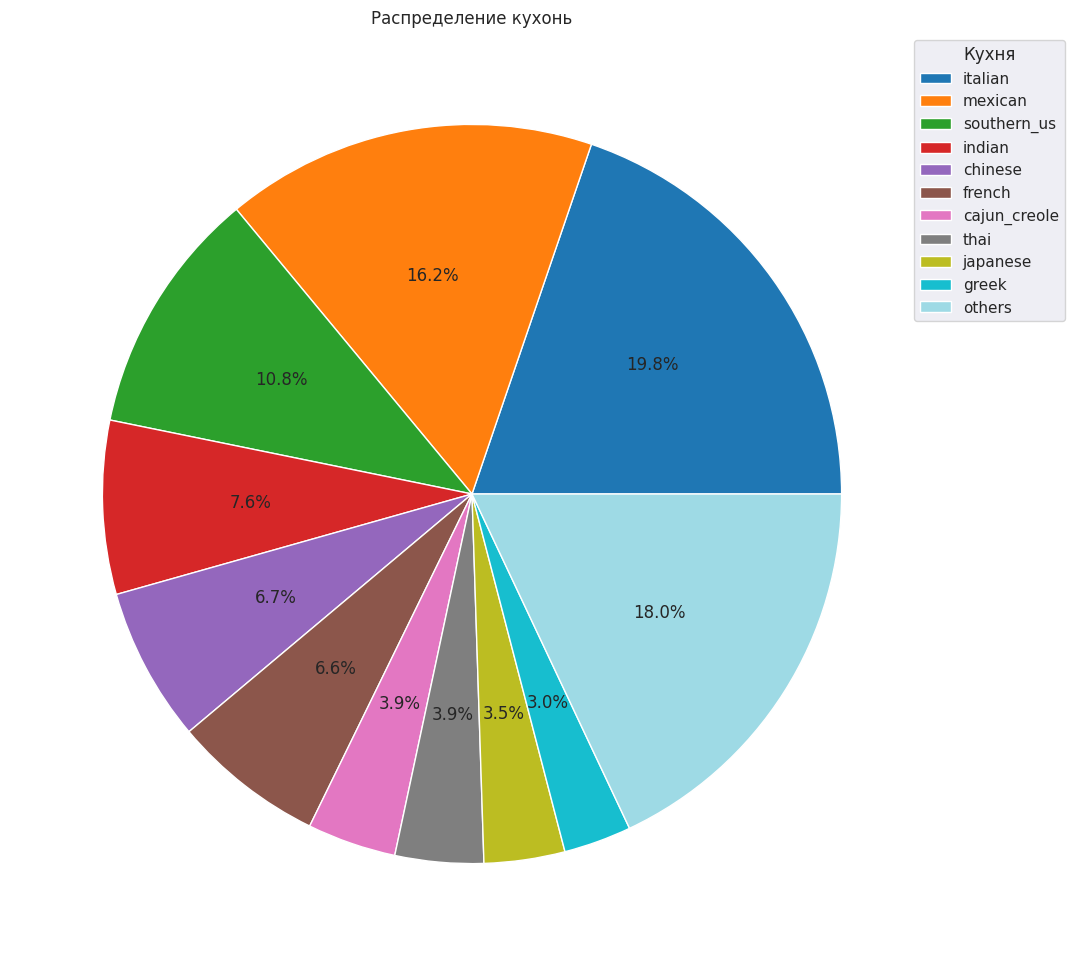

In [ ]:
# Подписи для легенды
labels = cuisine_plot.index


# График
cuisine_plot.plot.pie(figsize=(12, 12),
                      title='Распределение кухонь',
                      autopct='%1.1f%%',
                      labels=None,
                      cmap='tab20')

# loc - расположение
# bbox_to_anchor - расположение относительно самого графика по оси x, y
plt.legend(title='Кухня', loc='upper right',
labels=labels, bbox_to_anchor=(1.15, 1))

# Уберем подписи у самого графика
plt.ylabel(None);

Распределение кухонь в обучающем наборе данных показывает, что некоторые кухни, такие как итальянская, мексиканская и кухня южных штатов США, представлены гораздо больше, чем другие, например, ямайская или русская.

Это может оказать влияние на производительность модели, особенно в отношении менее представленных кухонь.

## Количество ингридиентов в кухнях

In [ ]:
# Подсчет общего количества уникальных ингредиентов
all_ingredients = sum(data['ingredients'], [])
unique_ingredients = set(all_ingredients)
total_unique_ingredients = len(unique_ingredients)

# Подсчет количества ингредиентов для каждой кухни
ingredients_per_cuisine = Counter()
for _, row in tqdm(data.iterrows()):
    ingredients_per_cuisine[row['cuisine']] += len(row['ingredients'])

# Среднее количество ингредиентов на рецепт для каждой кухни
average_ingredients_per_cuisine = {cuisine: total / cuisine_distribution[cuisine]
                                   for cuisine, total in ingredients_per_cuisine.items()}

# Сортируем итоговый словарь по значению (среднему количеству ингридиентов)
average_ingredients_per_cuisine = dict(sorted(average_ingredients_per_cuisine.items(), key=lambda item: item[1]))

39257it [00:01, 21734.68it/s]


In [ ]:
total_unique_ingredients, average_ingredients_per_cuisine

(6714,
 {'irish': 9.326283987915408,
  'brazilian': 9.607142857142858,
  'southern_us': 9.647697756788666,
  'british': 9.733668341708542,
  'japanese': 9.788031723143476,
  'french': 9.852050594097355,
  'italian': 9.922531580304202,
  'filipino': 10.018666666666666,
  'greek': 10.185886402753873,
  'russian': 10.246913580246913,
  'spanish': 10.456499488229273,
  'mexican': 10.887860727728985,
  'korean': 11.28606356968215,
  'chinese': 11.973146747352496,
  'jamaican': 12.162745098039215,
  'thai': 12.543478260869565,
  'cajun_creole': 12.624918032786885,
  'vietnamese': 12.699751861042184,
  'indian': 12.719463087248322,
  'moroccan': 12.97283950617284})

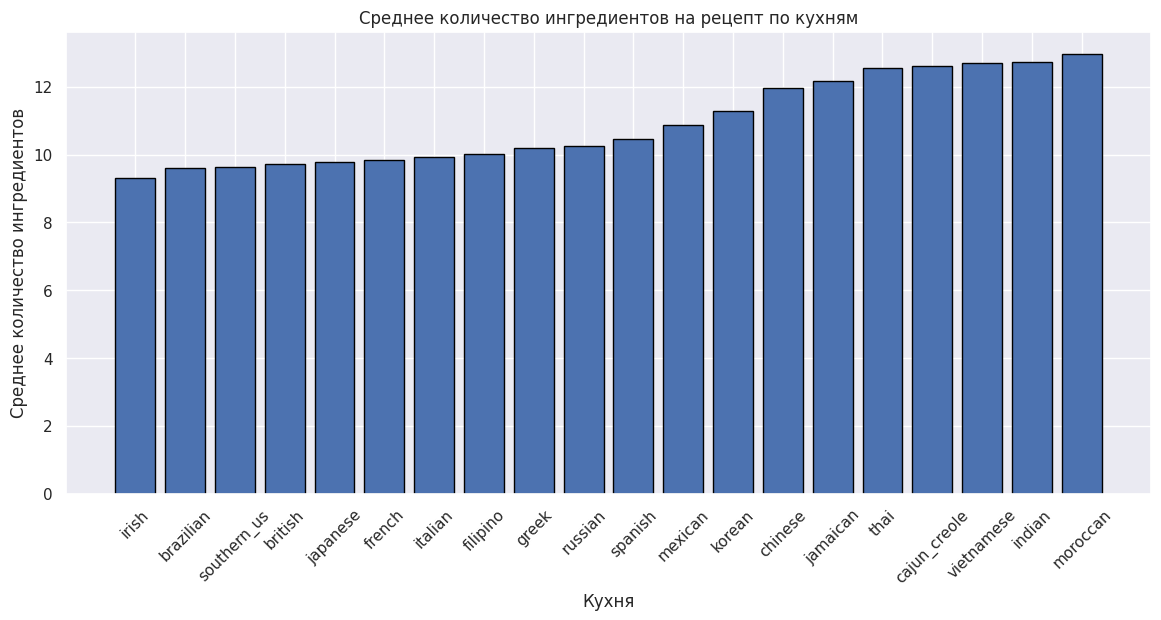

In [ ]:
# Визуализация среднего количества ингредиентов на кухню
plt.figure(figsize=(14, 6))
plt.bar(average_ingredients_per_cuisine.keys(),
        average_ingredients_per_cuisine.values(),
        edgecolor='black')
plt.title('Среднее количество ингредиентов на рецепт по кухням')
plt.xlabel('Кухня')
plt.ylabel('Среднее количество ингредиентов')
plt.xticks(rotation=45)
plt.show()

В датасете представлено 6714 уникальных ингредиентов.

Среднее количество ингредиентов на рецепт варьируется в зависимости от кухни. Например, ямайская кухня в среднем использует более 13 ингредиентов на рецепт, в то время как итальянская кухня использует около 9,8 ингредиента на рецепт.

Эти различия могут быть полезны для классификации кухонь.

Среднее количество ингредиентов на рецепт варьируется в зависимости от кухни. Например, ямайская кухня в среднем использует более 13 ингредиентов на рецепт, в то время как итальянская кухня использует около 9,8 ингредиента на рецепт. Эти различия могут быть полезны для классификации кухонь.

## Наиболее частые ингридиенты в кухнях

39257it [00:02, 19194.53it/s]


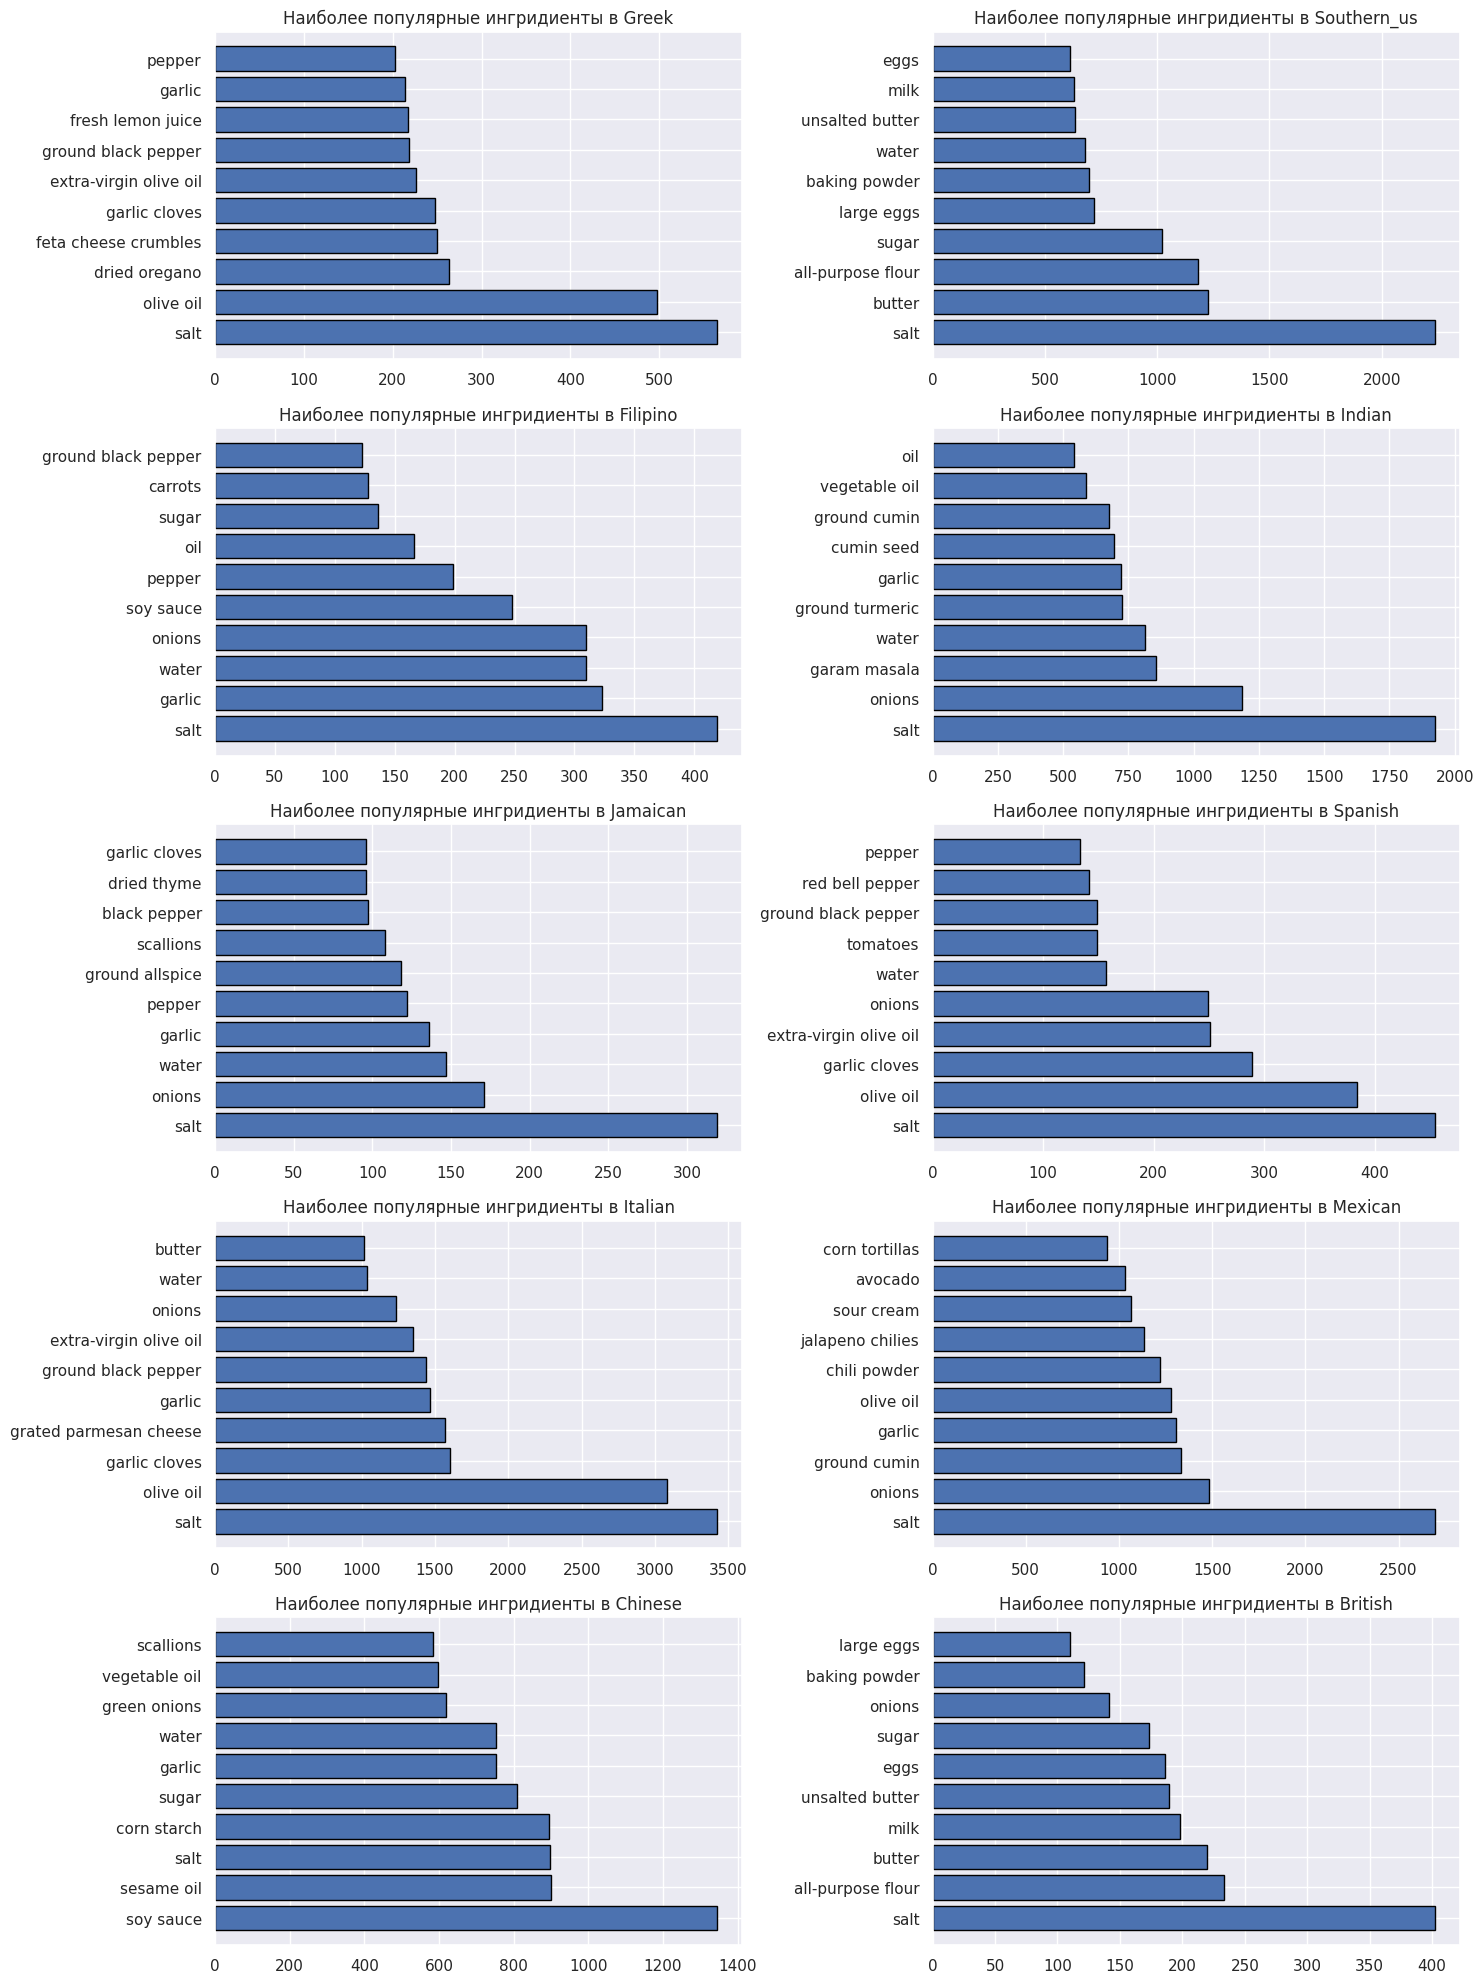

In [ ]:
# Агрегация ингредиентов для каждой кухни
ingredients_by_cuisine = {}
for _, row in tqdm(data.iterrows()):
    cuisine = row['cuisine']
    ingredients = row['ingredients']
    if cuisine not in ingredients_by_cuisine:
        ingredients_by_cuisine[cuisine] = Counter()
    ingredients_by_cuisine[cuisine].update(ingredients)

# Визуализация наиболее популярных ингредиентов для нескольких кухонь
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
cuisines_to_display = list(ingredients_by_cuisine.keys())[:10] # Отображение для первых четырех кухонь

for ax, cuisine in zip(axes.flatten(), cuisines_to_display):
    most_common_ingredients = ingredients_by_cuisine[cuisine].most_common(10)
    ingredients, counts = zip(*most_common_ingredients)
    ax.barh(ingredients, counts, edgecolor='black')
    ax.set_title(f'Наиболее популярные ингридиенты в {cuisine.capitalize()}')

plt.tight_layout()
plt.show()

## Количество ингридиентов в каждом рецепте

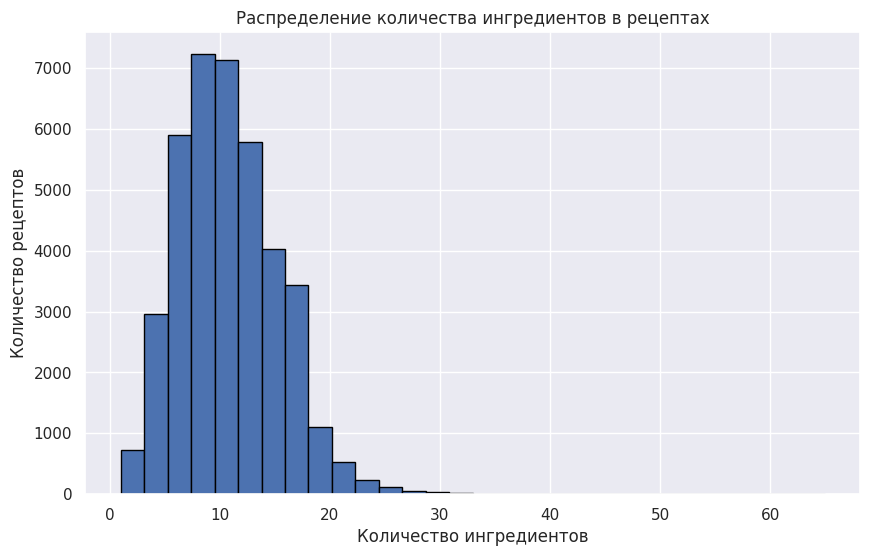

In [ ]:
# Расчет количества ингредиентов в каждом рецепте
num_ingredients_per_recipe = data['ingredients'].apply(len)

# Визуализация распределения количества ингредиентов в рецептах
plt.figure(figsize=(10, 6))
plt.hist(num_ingredients_per_recipe, bins=30, edgecolor='black')
plt.title('Распределение количества ингредиентов в рецептах')
plt.xlabel('Количество ингредиентов')
plt.ylabel('Количество рецептов')
plt.show()

In [ ]:
# Выводим описательную статистику для чисел
num_ingredients_per_recipe.describe()

count    39257.000000
mean        10.783911
std          4.422210
min          1.000000
25%          8.000000
50%         10.000000
75%         13.000000
max         65.000000
Name: ingredients, dtype: float64

Распределение количества ингредиентов в рецептах показывает, что в среднем рецепт содержит около 10,8 ингредиентов.

Большинство рецептов имеют от 8 до 13 ингредиентов, но есть и такие, в которых используется всего 1 ингредиент или до 60 ингредиентов.

Это разнообразие в количестве ингредиентов может влиять на выбор и настройку моделей машинного обучения.

# Выбор признаков и их кодирование

В качестве признаков для моделей используются ингредиенты.

Поскольку данные о ингредиентах представлены в виде текста, нам нужно будет применить технику векторизации, чтобы преобразовать эти текстовые данные в числовые признаки, которые можно использовать для обучения моделей.


Для выбора и кодирования признаков в этой задаче классификации кухонь по ингредиентам, наиболее подходящим подходом будет использование техники "мешка слов" (bag-of-words). Эта техника позволяет преобразовать текстовые данные (в данном случае списки ингредиентов) в числовые векторы, которые можно использовать для обучения моделей машинного обучения.

* Использование CountVectorizer: CountVectorizer создаст вектор для каждого рецепта, где каждый ингредиент представлен уникальным числом, а его важность в рецепте измеряется частотой его встречаемости.

* Альтернативный подход - TF-IDF: В качестве альтернативы можно использовать TfidfVectorizer, который не только учитывает частоту ингредиента в рецепте, но и уменьшает вес тех ингредиентов, которые часто встречаются во многих рецептах, что может помочь выделить более уникальные для каждой кухни ингредиенты.

В данной работе используется CountVectorizer


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Создание экземпляра CountVectorizer
vectorizer = CountVectorizer(lowercase=False)

# Создание экземпляра TfidfVectorizer
# vectorizer = TfidfVectorizer(lowercase=False)


# Объединение списка ингредиентов в одну строку для каждого рецепта
train_ingredients_combined = train_data['ingredients'].apply(lambda x: ' '.join(x))
test_ingredients_combined = test_data['ingredients'].apply(lambda x: ' '.join(x))

# Применение векторизации к обучающему и тестовому наборам
X_train = vectorizer.fit_transform(train_ingredients_combined)
X_test = vectorizer.transform(test_ingredients_combined)

# Подготовка меток классов
y_train = train_data['cuisine']
y_test = test_data['cuisine']

# Анализ признаков

In [ ]:
X_train.shape, X_test.shape

((27479, 3141), (11778, 3141))

Обучающий набор данных теперь содержит 3500 рецептов, представленных 73 уникальными признаками (ингредиентами).

Такое же количество признаков представлено и в тестовом наборе.

# Обучение моделей

In [ ]:
# Словарь для сохранения метрик работы
# Понадобится для визуализации результатов
RES = {}

Принцип обучения моделей

1. Обучение модели: Создадим и обучим модель на обучающем наборе данных.
2. Оценка производительности: Проверим производительность модели на тестовом наборе данных.
3. Настройка гиперпараметров (при необходимости): Используем кросс-валидацию для настройки гиперпараметров модели для улучшения её производительности.

## Логистическая регрессия

In [ ]:
# Создание модели логистической регрессии
log_reg_model = LogisticRegression(max_iter=10000, random_state=42)

# Обучение модели
log_reg_model.fit(X_train, y_train)

# Предсказание на тестовом наборе
y_pred = log_reg_model.predict(X_test)

# Вычисление точности
accuracy = accuracy_score(y_test, y_pred)
RES['Linear regression'] = accuracy
accuracy

0.7792494481236203

# Случайный лес

Здесь и ниже есть подбор параметров для примера. Можно использовать и их, добавив соответсвующие параметры

In [ ]:
# Создание модели RandomForestClassifier
random_forest_model = RandomForestClassifier(random_state=42)

# Определение сетки гиперпараметров для поиска
param_grid = {
    'n_estimators': [100, 200, 300],  # Количество деревьев в лесу
    'max_depth': [10, 20, 30],        # Максимальная глубина дерева
    'min_samples_split': [2, 4, 6]    # Минимальное количество образцов, необходимых для разделения узла
}

# Создание GridSearchCV для поиска лучших гиперпараметров
grid_search = GridSearchCV(random_forest_model, param_grid,
                           cv=3, n_jobs=-1, scoring='accuracy')

# Обучение модели
grid_search.fit(X_train, y_train)

# Лучшие параметры и лучшая модель
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Предсказание на тестовом наборе
y_pred = best_model.predict(X_test)

# Вычисление точности
accuracy = accuracy_score(y_test, y_pred)
RES['Random forest'] = accuracy
accuracy

In [ ]:
random_forest = RandomForestClassifier(random_state=42)

# Обучение модели
random_forest.fit(X_train, y_train)

# Предсказание на тестовом наборе
y_pred = random_forest.predict(X_test)

# Вычисление точности
accuracy = accuracy_score(y_test, y_pred)
RES['Random forest'] = accuracy
accuracy

0.7417218543046358

## XgBoost

 Данный метод - градиентный бустинг.

 Градиентный бустинг последовательно строит деревья решений таким образом, что каждое следующее дерево пытается исправить ошибки, сделанные предыдущими деревьями.

XGBoost требует, чтобы метки классов были целочисленными значениями от 0 до [количество классов - 1].

Необходимо преобразовать метки классов (кухни) из строковых названий в целочисленные метки.

In [ ]:
# Создание и обучение LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
# Создание модели XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False,
                              eval_metric='mlogloss', random_state=42)

# Определение сетки гиперпараметров для поиска
param_grid = {
    'n_estimators': [100, 200, 300],     # Количество деревьев
    'max_depth': [3, 6, 9],              # Максимальная глубина дерева
    'learning_rate': [0.01, 0.1, 0.2]    # Скорость обучения
}

# Создание GridSearchCV для поиска лучших гиперпараметров
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, n_jobs=-1,
                           scoring='accuracy')

# Обучение модели
grid_search.fit(X_train, y_train_encoded)

# Лучшие параметры и лучшая модель
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Предсказание на тестовом наборе
y_pred_xgb = best_model.predict(X_test)

# Вычисление точности
accuracy = accuracy_score(y_test_encoded, y_pred_xgb)
RES['XGB'] = accuracy
accuracy

In [ ]:
# Создание модели XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False,
                              eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train_encoded)



# Предсказание на тестовом наборе
y_pred_xgb = xgb_model.predict(X_test)

# Вычисление точности
accuracy = accuracy_score(y_test_encoded, y_pred_xgb)
RES['XGB'] = accuracy
accuracy

0.7796739684156903

## Нейронная сеть

Можно использовать callbacks в Keras.

Можно использовать EarlyStopping для остановки обучения, если loss на валидационном наборе данных не улучшается на протяжении заданного числа эпох.

ModelCheckpoint используется для сохранения модели в том состоянии, когда она показывает лучшее значение val_loss.

In [ ]:
# Кодирование меток классов
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Преобразование разреженных матриц в плотные
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Определение количества классов
num_classes = len(np.unique(y_train_encoded))

In [ ]:
X_train_dense.shape, X_test_dense.shape

((27479, 3141), (11778, 3141))

In [ ]:
num_classes

20

In [ ]:
# Создание модели нейронной сети
model = Sequential()
model.add(Dense(512, activation='LeakyReLU', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Компиляция модели
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

# Создание коллбэков для ранней остановки и сохранения лучшей модели
early_stopping = EarlyStopping(monitor='val_loss', patience=5,
                               verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss',
                                   mode='min', save_best_only=True, verbose=1)

# Обучение модели
model.fit(X_train_dense, y_train_encoded, batch_size=128, epochs=25,
          validation_data=(X_test_dense, y_test_encoded),
          callbacks=[early_stopping, model_checkpoint])

# Загрузка лучшей модели
model.load_weights('best_model.h5')

# Оценка лучшей модели на тестовых данных
test_loss, test_acc = model.evaluate(X_test_dense, y_test_encoded)
print('Test Accuracy:', test_acc)

Epoch 1/25
214/215 [============================>.] - ETA: 0s - loss: 1.5208 - accuracy: 0.5772
Epoch 1: val_loss improved from inf to 0.91485, saving model to best_model.h5
215/215 [==============================] - 7s 20ms/step - loss: 1.5199 - accuracy: 0.5775 - val_loss: 0.9149 - val_accuracy: 0.7285
Epoch 2/25
205/215 [===========================>..] - ETA: 0s - loss: 0.9194 - accuracy: 0.7294
Epoch 2: val_loss improved from 0.91485 to 0.80776, saving model to best_model.h5
215/215 [==============================] - 1s 7ms/step - loss: 0.9151 - accuracy: 0.7310 - val_loss: 0.8078 - val_accuracy: 0.7618
Epoch 3/25
210/215 [============================>.] - ETA: 0s - loss: 0.7803 - accuracy: 0.7650
Epoch 3: val_loss improved from 0.80776 to 0.76667, saving model to best_model.h5
215/215 [==============================] - 1s 7ms/step - loss: 0.7805 - accuracy: 0.7652 - val_loss: 0.7667 - val_accuracy: 0.7764
Epoch 4/25
214/215 [============================>.] - ETA: 0s - loss: 0.7035

In [ ]:
RES['Neural Network'] = test_acc

# Подсчет метрик

In [ ]:
RES

{'Linear regression': 0.7792494481236203,
 'Random forest': 0.7417218543046358,
 'XGB': 0.7796739684156903,
 'Neural Network': 0.78111732006073}

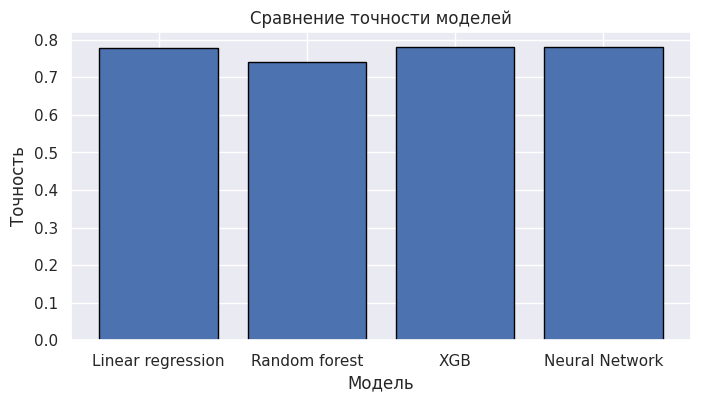

In [ ]:
# Данные для построения графика
models = list(RES.keys())
accuracy_values = list(RES.values())

# Создание столбцовой диаграммы
plt.figure(figsize=(8, 4))
plt.bar(models, accuracy_values, edgecolor='black')

# Добавление заголовка и меток
plt.title('Сравнение точности моделей')
plt.xlabel('Модель')
plt.ylabel('Точность')

# Отображение диаграммы
plt.show()

# Анализ результатов

В результате работы на представленном наборе данных были сравнены четыре различных моделей машинного обучения: линейной регрессии, случайного леса (Random forest), XGBoost (XGB) и нейронной сети (Neural Network).

Все модели показывают сопоставимые результаты точности, которые находятся в диапазоне от примерно 0.77 до 0.78.

Выводы:

* Близкие результаты: То, что все модели имеют близкие показатели точности, может свидетельствовать о том, что они достигли определённого "потолка" производительности на имеющихся данных.

Это может быть признаком того, что для всех моделей доступна одинаковая информация из данных и что они извлекают из этих данных максимум возможного.

* Сложность модели не гарантирует лучшую производительность: Более сложная модель, такая как нейронная сеть, не обязательно показывает лучшую точность по сравнению с более простыми моделями, такими как линейная регрессия или случайный лес.

Это может указывать на то, что сложность модели должна быть соответствующим образом настроена и адаптирована к конкретной задаче.

* Дальнейшие эксперименты: Возможно, стоит попробовать другие подходы к моделированию, такие как ансамблевые методы, блендинг или стекинг различных моделей для улучшения результатов.